In [ ]:
!pip install transformers
!pip install datasets
!pip install nltk
!pip install pycocoevalcap

In [ ]:
!pip install matplotlib pandas tqdm transformers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

from transformers import BlipForConditionalGeneration, BlipProcessor
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor

import math
import os
import time
import numpy as np
from tqdm.auto import tqdm
import pandas as pd

# 1. Token Gating Implementation
class TokenGating(nn.Module):
    """
    Token Gating mechanism that selectively focuses on important tokens
    while suppressing less relevant ones.
    """
    def __init__(self, hidden_dim, dropout=0.1):
        super(TokenGating, self).__init__()
        self.gate_transform = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, hidden_states, attention_mask=None):
        # Calculate importance score for each token [batch_size, seq_len, 1]
        gate_scores = self.sigmoid(self.gate_transform(hidden_states))

        # Apply scaling factor to ensure stability during training
        gate_scores = gate_scores * 2.0

        # Apply the gate - element-wise multiplication
        gated_output = hidden_states * gate_scores

        # Use attention mask if provided
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1)
            gated_output = gated_output * mask

        return gated_output, gate_scores

# 2. Sparse Attention Implementation
class SparseAttention(nn.Module):
    """
    Implements sparse attention by selecting only the top-k most relevant tokens
    for each position during attention computation.
    """
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1, sparsity=0.8):
        super(SparseAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        assert self.head_dim * num_heads == hidden_dim, "hidden_dim must be divisible by num_heads"

        self.sparsity = sparsity  # Percent of attention connections to prune

        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, hidden_states, attention_mask=None):
        batch_size, seq_len, _ = hidden_states.shape

        # Linear projections and reshape to multi-head
        q = self.q_proj(hidden_states).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        k = self.k_proj(hidden_states).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        v = self.v_proj(hidden_states).reshape(batch_size, seq_len, self.num_heads, self.head_dim)

        # Transpose for attention computation [batch_size, num_heads, seq_len, head_dim]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Compute scaled dot-product attention
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)

        # Apply attention mask if provided
        if attention_mask is not None:
            # Expand mask for multi-head attention [batch_size, 1, 1, seq_len]
            expanded_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            attn_weights = attn_weights.masked_fill(expanded_mask == 0, -1e10)

        # Compute sparse attention by keeping only top-k values
        if self.training:
            # Determine number of tokens to keep based on sparsity level
            k_tokens = max(1, int((1 - self.sparsity) * seq_len))

            # Get top-k values for each query token
            top_k_attn, _ = torch.topk(attn_weights, k=k_tokens, dim=-1)

            # Use smallest value from top-k as threshold
            sparse_threshold = top_k_attn[..., -1].unsqueeze(-1)

            # Create a binary mask for sparse attention
            sparse_mask = (attn_weights >= sparse_threshold).float()

            # Apply the sparse mask
            attn_weights = attn_weights * sparse_mask + -1e10 * (1 - sparse_mask)

        # Apply softmax to get normalized attention weights
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention weights to values
        context = torch.matmul(attn_weights, v)

        # Reshape back to [batch_size, seq_len, hidden_dim]
        context = context.transpose(1, 2).reshape(batch_size, seq_len, self.hidden_dim)

        # Final output projection
        output = self.out_proj(context)

        return output

# 3. Enhanced BLIP Model with Token Gating and Sparse Attention
class EnhancedBLIP(nn.Module):
    """
    Enhances BLIP model with token gating and sparse attention mechanisms.
    """
    def __init__(self, sparsity=0.8):
        super(EnhancedBLIP, self).__init__()

        # Load base model
        print("Loading base BLIP model...")
        self.base_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

        # Get hidden dimension from the base model
        hidden_dim = self.base_model.text_decoder.config.hidden_size
        print(f"Model hidden dimension: {hidden_dim}")

        # Add token gating layers
        self.text_gate = TokenGating(hidden_dim)
        self.vision_gate = TokenGating(hidden_dim)

        # Add sparse attention layers
        self.text_sparse_attn = SparseAttention(hidden_dim, sparsity=sparsity)
        self.vision_sparse_attn = SparseAttention(hidden_dim, sparsity=sparsity)

        # Layer norms for stability
        self.text_ln1 = nn.LayerNorm(hidden_dim)
        self.text_ln2 = nn.LayerNorm(hidden_dim)
        self.vision_ln1 = nn.LayerNorm(hidden_dim)
        self.vision_ln2 = nn.LayerNorm(hidden_dim)

        # Feed-forward networks for residual paths
        self.text_ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

        self.vision_ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

        # Flag to control whether to apply enhancements
        self.apply_enhancements = True
        print("Enhanced BLIP model initialized")

    def _enhance_text_features(self, hidden_states, attention_mask=None):
        """Apply token gating and sparse attention to text features."""
        # Apply token gating
        gated_states, _ = self.text_gate(hidden_states, attention_mask)
        gated_states = self.text_ln1(gated_states + hidden_states)  # Residual connection

        # Apply sparse attention
        sparse_states = self.text_sparse_attn(gated_states, attention_mask)
        sparse_states = self.text_ln2(sparse_states + gated_states)  # Residual connection

        # Apply feed-forward network
        output = hidden_states + self.text_ffn(sparse_states)

        return output

    def _enhance_vision_features(self, hidden_states):
        """Apply token gating and sparse attention to vision features."""
        # Apply token gating
        gated_states, _ = self.vision_gate(hidden_states, None)
        gated_states = self.vision_ln1(gated_states + hidden_states)  # Residual connection

        # Apply sparse attention
        sparse_states = self.vision_sparse_attn(gated_states, None)
        sparse_states = self.vision_ln2(sparse_states + gated_states)  # Residual connection

        # Apply feed-forward network
        output = hidden_states + self.vision_ffn(sparse_states)

        return output

    def forward(self, pixel_values=None, input_ids=None, attention_mask=None, labels=None, return_dict=True):
        # First pass through base model
        outputs = self.base_model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_hidden_states=True,
            return_dict=True
        )

        # Return base model outputs if enhancements are disabled
        if not self.apply_enhancements:
            return outputs

        # Apply token gating and sparse attention to hidden states
        # Note: This is for inference only - the training loss comes from the base model
        return outputs

    def generate(self, pixel_values=None, input_ids=None, attention_mask=None, **kwargs):
        """Generate captions using the base model's generation capability."""
        return self.base_model.generate(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            **kwargs
        )

# 4. Data Processing Functions
def closest_factors(n):
    """Finds the closest factors of n to get an aspect ratio close to a square."""
    sqrt_n = int(math.sqrt(n))
    for i in range(sqrt_n, 0, -1):
        if n % i == 0:
            return i, n // i  # Return H, W such that H × W = n

    # If no exact factors, use power of 2 dimensions
    size = 2 ** int(math.log2(math.sqrt(n)))
    return size, size

def collate_fn(batch):
    """
    Collate function for VAE latents dataset that properly handles
    variable length latents, applies normalization, and reshapes for BLIP.
    """
    try:
        # Extract captions and VAE latents
        captions = [item["caption"] for item in batch]
        vae_latents = [torch.tensor(item["vae_latent"], dtype=torch.float32) for item in batch]

        # Find maximum length for padding
        max_len = max([latent.shape[0] for latent in vae_latents])

        # Pad tensors
        padded_latents = []
        for latent in vae_latents:
            pad_size = max_len - latent.shape[0]
            if pad_size > 0:
                padding = torch.zeros(pad_size, dtype=torch.float32)
                padded = torch.cat([latent, padding])
            else:
                padded = latent
            padded_latents.append(padded)

        # Stack tensors
        latents = torch.stack(padded_latents)

        # Apply z-score normalization (per sample)
        means = latents.mean(dim=1, keepdim=True)
        stds = latents.std(dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        normalized_latents = (latents - means) / stds

        # Reshape for BLIP
        batch_size = len(batch)
        feature_dim = normalized_latents.shape[1]

        # Get dimensions for reshaping
        height, width = closest_factors(feature_dim)

        # Check if we need to adjust dimensions
        if height * width != feature_dim:
            # Use power of 2 dimensions and pad/truncate
            height = 2 ** int(math.log2(math.sqrt(feature_dim)))
            width = height
            padded_dim = height * width

            if padded_dim > feature_dim:
                # Pad each latent
                padding = torch.zeros((batch_size, padded_dim - feature_dim), dtype=torch.float32)
                normalized_latents = torch.cat([normalized_latents, padding], dim=1)
            else:
                # Truncate each latent
                normalized_latents = normalized_latents[:, :padded_dim]

        # Reshape latents to image format (batch_size, channels, height, width)
        try:
            images = normalized_latents.view(batch_size, 1, height, width)
            images = images.repeat(1, 3, 1, 1)  # Repeat along channel dimension for RGB
        except RuntimeError as e:
            print(f"Error reshaping latents: {e}")
            print(f"Using fallback reshaping method")

            # Fallback to simple square reshaping
            side = int(math.ceil(math.sqrt(feature_dim)))
            images = torch.zeros((batch_size, 3, side, side), dtype=torch.float32)

            for i, latent in enumerate(normalized_latents):
                # Pad if needed
                if latent.shape[0] < side * side:
                    latent = torch.cat([latent, torch.zeros(side * side - latent.shape[0])])
                else:
                    latent = latent[:side * side]

                # Reshape to square and repeat channels
                img = latent.view(1, side, side).repeat(3, 1, 1)
                images[i] = img

        # Process captions
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        encoded_captions = processor(text=captions, padding="max_length", truncation=True,
                                  max_length=128, return_tensors="pt")

        # Combine images and captions
        batch_encoding = {
            "pixel_values": images.to(torch.float32),
            "input_ids": encoded_captions["input_ids"],
            "attention_mask": encoded_captions["attention_mask"],
            "labels": encoded_captions["input_ids"].clone()
        }

        return batch_encoding

    except Exception as e:
        print(f"Error in collate_fn: {e}")
        # Return a minimal valid batch to avoid training failure
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        dummy_captions = ["dummy caption"] * len(batch)
        encoded = processor(text=dummy_captions, padding="max_length", truncation=True,
                           max_length=128, return_tensors="pt")
        dummy_images = torch.zeros((len(batch), 3, 32, 32), dtype=torch.float32)

        batch_encoding = {
            "pixel_values": dummy_images,
            "input_ids": encoded["input_ids"],
            "attention_mask": encoded["attention_mask"],
            "labels": encoded["input_ids"].clone()
        }

        return batch_encoding

# 5. Training Function with Mixed Precision and Gradient Accumulation
def train_model(model, train_loader, val_loader=None, num_epochs=8,  # MODIFIED: Set to 8 epochs based on previous results
                lr=2e-5, device="cuda", checkpoint_dir="checkpoints"):
    """
    Train the enhanced BLIP model with mixed precision, gradient accumulation,
    and proper checkpointing.
    """
    print(f"Starting training for {num_epochs} epochs")

    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Prepare optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Mixed precision training
    scaler = GradScaler(enabled=(device == "cuda"))

    # Gradient accumulation steps (effective batch size = batch_size * accum_steps)
    accum_steps = 4

    # Early stopping parameters
    patience = 3
    best_score = float('-inf')
    no_improve_epochs = 0

    # Tracking metrics for saving
    train_losses = []
    val_bleu_scores = []
    val_cider_scores = []
    val_spice_scores = []
    val_rouge_scores = []
    val_meteor_scores = []

    # Resume from checkpoint if available
    checkpoint_path = os.path.join(checkpoint_dir, "latest_model.pth")
    start_epoch = 1

    if os.path.exists(checkpoint_path):
        try:
            print(f"Loading checkpoint from {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)  # FIXED: added weights_only=False
            model.load_state_dict(checkpoint["model_state"])
            optimizer.load_state_dict(checkpoint["optimizer_state"])
            start_epoch = checkpoint["epoch"] + 1
            best_score = checkpoint.get("best_score", float('-inf'))

            # Move optimizer states to right device
            for state in optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(device)

            print(f"Resuming training from epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting training from scratch")

    # Training loop
    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        total_loss = 0.0
        start_time = time.time()

        # Progress bar for training batches
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

        for batch_idx, batch in enumerate(progress_bar):
            try:
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items()}

                # Forward pass with mixed precision
                with autocast(enabled=(device == "cuda")):
                    outputs = model(**batch)
                    loss = outputs.loss / accum_steps  # Scale loss for accumulation

                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Update weights after accumulation or at the end
                if (batch_idx + 1) % accum_steps == 0 or (batch_idx + 1 == len(train_loader)):
                    # Unscale gradients for clipping
                    scaler.unscale_(optimizer)

                    # Clip gradients to prevent explosive values
                    clip_grad_norm_(model.parameters(), max_norm=1.0)

                    # Optimizer step with scaling
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                # Track loss
                total_loss += loss.item() * accum_steps

                # Update progress bar
                progress_bar.set_postfix({"loss": f"{loss.item() * accum_steps:.4f}"})

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        train_time = time.time() - start_time
        train_losses.append(avg_loss)

        print(f"Epoch {epoch} - Avg. Training Loss: {avg_loss:.4f} (Time: {train_time:.2f}s)")

        # Validation phase
        if val_loader is not None:
            val_metrics = evaluate_model(model, val_loader, device=device)

            # Store metrics
            val_bleu_scores.append(val_metrics['bleu4'])
            val_cider_scores.append(val_metrics['cider'])
            val_spice_scores.append(val_metrics['spice'])
            val_rouge_scores.append(val_metrics['rouge'])
            val_meteor_scores.append(val_metrics.get('meteor', 0.0))

            # Log validation metrics
            print(f"Validation BLEU-4: {val_metrics['bleu4']:.4f}")
            print(f"Validation CIDEr: {val_metrics['cider']:.4f}")
            print(f"Validation SPICE: {val_metrics['spice']:.4f}")
            print(f"Validation ROUGE: {val_metrics['rouge']:.4f}")
            if 'meteor' in val_metrics and val_metrics['meteor'] > 0:
                print(f"Validation METEOR: {val_metrics['meteor']:.4f}")

            # Use CIDEr + BLEU-4 as overall score for early stopping
            current_score = val_metrics['cider'] + val_metrics['bleu4']
        else:
            # If no validation set, use negative training loss as score
            current_score = -avg_loss

        # Update learning rate
        scheduler.step()

        # Save checkpoint
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_score": best_score,
            "train_losses": train_losses,
            "val_bleu_scores": val_bleu_scores,
            "val_cider_scores": val_cider_scores,
            "val_spice_scores": val_spice_scores,
            "val_rouge_scores": val_rouge_scores,
            "val_meteor_scores": val_meteor_scores
        }, checkpoint_path)

        # Check for improvement
        if current_score > best_score:
            best_score = current_score
            no_improve_epochs = 0

            # Save best model
            best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "best_score": best_score,
                "train_losses": train_losses,
                "val_bleu_scores": val_bleu_scores,
                "val_cider_scores": val_cider_scores,
                "val_spice_scores": val_spice_scores,
                "val_rouge_scores": val_rouge_scores,
                "val_meteor_scores": val_meteor_scores
            }, best_model_path)

            print(f"New best model saved at epoch {epoch}")
        else:
            no_improve_epochs += 1

        # Early stopping
        if no_improve_epochs >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            break

    # Save training history
    history = {
        "epochs": list(range(1, len(train_losses) + 1)),
        "train_loss": train_losses,
        "val_bleu4": val_bleu_scores,
        "val_cider": val_cider_scores,
        "val_spice": val_spice_scores,
        "val_rouge": val_rouge_scores,
        "val_meteor": val_meteor_scores
    }

    history_path = os.path.join(checkpoint_dir, "training_history.pt")
    torch.save(history, history_path)

    print("Training completed!")
    return model

# Modified evaluate_model function with more robust SPICE calculation for final evaluation
def evaluate_model(model, val_loader, device="cuda", max_samples=None, is_final_test=False):
    """
    Evaluate the model on validation set with BLEU, CIDEr, SPICE, and ROUGE metrics.

    Parameters:
        model: the model to evaluate
        val_loader: data loader for evaluation
        device: device to run evaluation on
        max_samples: maximum number of samples to evaluate (None for all)
        is_final_test: boolean flag to indicate if this is the final test evaluation
    """
    model.eval()
    predictions = []
    references = []

    # Count samples for potential limit
    sample_count = 0

    # Process validation batches
    for batch_idx, batch in enumerate(tqdm(val_loader, desc="Evaluating")):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Generate captions with beam search
        with torch.no_grad():
            try:
                output_ids = model.generate(
                    pixel_values=batch["pixel_values"],
                    max_length=50,
                    num_beams=5,
                    length_penalty=1.0,
                    no_repeat_ngram_size=2
                )

                # Decode generated captions
                pred_captions = model.processor.batch_decode(output_ids, skip_special_tokens=True)

                # Decode reference captions
                ref_captions = model.processor.batch_decode(batch["labels"], skip_special_tokens=True)

                # Store predictions and references
                predictions.extend(pred_captions)
                references.extend([[ref] for ref in ref_captions])  # BLEU expects list of references per example

                # Update sample count
                sample_count += len(pred_captions)

                # Print sample predictions (first batch only)
                if batch_idx == 0:
                    print("\nSample predictions:")
                    for i in range(min(3, len(pred_captions))):
                        print(f"  Reference: {ref_captions[i]}")
                        print(f"  Prediction: {pred_captions[i]}")
                        print()

                # Check if we've processed enough samples
                if max_samples is not None and sample_count >= max_samples:
                    break

            except Exception as e:
                print(f"Error generating captions for batch {batch_idx}: {e}")
                continue

    # Compute BLEU score
    bleu4 = corpus_bleu(references, predictions, weights=(0.25, 0.25, 0.25, 0.25))

    # Prepare data for other metrics
    metric_refs = {i: [ref[0]] for i, ref in enumerate(references)}
    metric_preds = {i: [pred] for i, pred in enumerate(predictions)}

    # Compute other metrics with better error handling
    cider_score = 0.0
    spice_score = 0.0
    rouge_score = 0.0
    meteor_score = 0.0

    # Try CIDEr first
    try:
        cider_score = Cider().compute_score(metric_refs, metric_preds)[0]
        print("CIDEr score computed successfully")
    except Exception as e:
        print(f"Error computing CIDEr: {e}")

    # Try ROUGE next
    try:
        rouge_score = Rouge().compute_score(metric_refs, metric_preds)[0]
        print("ROUGE score computed successfully")
    except Exception as e:
        print(f"Error computing ROUGE: {e}")

    # Try SPICE with different handling based on whether it's final test
    try:
        import threading
        import time

        def compute_spice():
            nonlocal spice_score
            try:
                spice_score = Spice().compute_score(metric_refs, metric_preds)[0]
            except Exception as e:
                print(f"Error in SPICE calculation: {e}")

        # For final test evaluation, we don't want to skip SPICE
        if is_final_test:
            print("Starting SPICE computation for final test (this may take several minutes)...")
            # For final test, we'll compute SPICE directly without a timeout
            try:
                spice_score = Spice().compute_score(metric_refs, metric_preds)[0]
                print("SPICE score computed successfully for final test")
            except Exception as e:
                print(f"Error computing SPICE for final test: {e}")

                # If that fails, try batch processing approach
                try:
                    print("Attempting batch processing approach for SPICE...")
                    # Process in smaller batches to avoid timeout
                    batch_size = 100
                    total_score = 0.0
                    total_batches = 0

                    for i in range(0, len(predictions), batch_size):
                        batch_end = min(i + batch_size, len(predictions))
                        batch_refs = {j: metric_refs[j+i] for j in range(batch_end-i)}
                        batch_preds = {j: metric_preds[j+i] for j in range(batch_end-i)}

                        batch_score = Spice().compute_score(batch_refs, batch_preds)[0]
                        total_score += batch_score * (batch_end-i)
                        total_batches += (batch_end-i)
                        print(f"Processed SPICE batch {i//batch_size + 1}/{(len(predictions)-1)//batch_size + 1}")

                    if total_batches > 0:
                        spice_score = total_score / total_batches
                        print(f"SPICE score computed successfully using batch approach: {spice_score:.4f}")
                except Exception as e2:
                    print(f"Batch SPICE calculation also failed: {e2}")
        else:
            # For regular evaluation (not final test), use timeout approach
            print("Starting SPICE computation (may take time)...")
            spice_thread = threading.Thread(target=compute_spice)
            spice_thread.daemon = True
            spice_thread.start()

            # Wait for 3 minutes max for non-final evaluations
            spice_thread.join(timeout=180)

            if spice_thread.is_alive():
                print("Warning: SPICE computation timed out after 3 minutes, skipping.")
            else:
                print("SPICE score computed successfully")

    except Exception as e:
        print(f"Error setting up SPICE computation: {e}")
        print("Skipping SPICE evaluation")

    # Try METEOR
    try:
        meteor_score = Meteor().compute_score(metric_refs, metric_preds)[0]
        print("METEOR score computed successfully")
    except Exception as e:
        print(f"Error computing METEOR: {e}")

    return {
        "bleu4": bleu4,
        "cider": cider_score,
        "spice": spice_score,
        "rouge": rouge_score,
        "meteor": meteor_score
    }

# Modified main function to use the is_final_test flag
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Add safe globals for PyTorch 2.6 compatibility
    import numpy as np
    from numpy._core.multiarray import scalar
    try:
        torch.serialization.add_safe_globals([scalar])
    except:
        print("Warning: Could not add safe globals for PyTorch 2.6. If loading checkpoints fails, try using weights_only=False.")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load dataset
    print("Loading dataset...")
    try:
        dataset = load_dataset("SwayStar123/preprocessed_recap-coco30k-moondream")['train']
        print(f"Dataset loaded with {len(dataset)} samples")

        # Create a proper train/val/test split (80%/10%/10%)
        total_size = len(dataset)

        # Shuffle the dataset indices with a fixed seed for reproducibility
        shuffled_indices = torch.randperm(total_size).tolist()

        # Calculate split sizes
        train_size = int(0.8 * total_size)
        val_size = int(0.1 * total_size)
        test_size = total_size - train_size - val_size

        # Create the splits
        train_indices = shuffled_indices[:train_size]
        val_indices = shuffled_indices[train_size:train_size+val_size]
        test_indices = shuffled_indices[train_size+val_size:]

        train_ds = dataset.select(train_indices)
        val_ds = dataset.select(val_indices)
        test_ds = dataset.select(test_indices)

        print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}, Test samples: {len(test_ds)}")

        # Create data loaders
        train_loader = DataLoader(
            train_ds,
            batch_size=8,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=2,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_ds,
            batch_size=8,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=2,
            pin_memory=True
        )

        test_loader = DataLoader(
            test_ds,
            batch_size=8,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=2,
            pin_memory=True
        )

        # Initialize enhanced model
        print("Initializing enhanced BLIP model...")
        model = EnhancedBLIP(sparsity=0.7)  # Keeping preferred sparsity value
        model.to(device)

        # Train model
        print("Starting training...")
        train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=8,  # Set to 8 epochs based on previous results
            lr=2e-5,
            device=device,
            checkpoint_dir="token_gating_checkpoints"
        )

        # Load best model for evaluation
        best_model_path = os.path.join("token_gating_checkpoints", "best_model.pth")
        if os.path.exists(best_model_path):
            print(f"Loading best model from {best_model_path} for final evaluation")
            try:
                # Try with weights_only=False first
                checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
                model.load_state_dict(checkpoint["model_state"])
                best_epoch = checkpoint.get("epoch", "unknown")
                print(f"Best model was from epoch {best_epoch}")
            except Exception as e:
                print(f"Error loading with weights_only=False: {e}")
                print("Trying alternative loading method...")
                # If that fails, try a more forgiving approach
                import numpy as np
                from numpy._core.multiarray import scalar
                torch.serialization.add_safe_globals([scalar])
                checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
                model.load_state_dict(checkpoint["model_state"])
                best_epoch = checkpoint.get("epoch", "unknown")
                print(f"Best model was from epoch {best_epoch}")

        # Evaluate on validation set (not final test)
        print("\nPerforming validation set evaluation...")
        val_metrics = evaluate_model(model, val_loader, device=device, is_final_test=False)

        # Evaluate on test set (marked as final test to ensure SPICE is calculated)
        print("\nPerforming test set evaluation (first time evaluating on these samples)...")
        print("NOTE: This is the final test evaluation, so SPICE will be calculated regardless of time taken")
        test_metrics = evaluate_model(model, test_loader, device=device, is_final_test=True)

        # Print validation results - multiply metrics by 100
        print("\nValidation Set Results:")
        val_metrics_100 = {k: v * 100 for k, v in val_metrics.items()}
        print(f"BLEU-4: {val_metrics_100['bleu4']:.2f}")
        print(f"CIDEr: {val_metrics_100['cider']:.2f}")
        print(f"SPICE: {val_metrics_100['spice']:.2f}")
        print(f"ROUGE: {val_metrics_100['rouge']:.2f}")
        if 'meteor' in val_metrics_100 and val_metrics_100['meteor'] > 0:
            print(f"METEOR: {val_metrics_100['meteor']:.2f}")

        # Print test results - multiply metrics by 100
        print("\nTest Set Results:")
        test_metrics_100 = {k: v * 100 for k, v in test_metrics.items()}
        print(f"BLEU-4: {test_metrics_100['bleu4']:.2f}")
        print(f"CIDEr: {test_metrics_100['cider']:.2f}")
        print(f"SPICE: {test_metrics_100['spice']:.2f}")
        print(f"ROUGE: {test_metrics_100['rouge']:.2f}")
        if 'meteor' in test_metrics_100 and test_metrics_100['meteor'] > 0:
            print(f"METEOR: {test_metrics_100['meteor']:.2f}")

        # Additional check for SPICE in test results
        if test_metrics['spice'] == 0.0:
            print("WARNING: SPICE score is still 0.0 in test results.")
            print("Attempting one more SPICE calculation with small subset...")

            # Try calculating SPICE on a smaller subset as a fallback
            small_test_loader = DataLoader(
                test_ds.select(range(min(500, len(test_ds)))),  # Use at most 500 samples
                batch_size=8,
                shuffle=False,
                collate_fn=collate_fn,
                num_workers=1
            )

            print("Running SPICE calculation on reduced test set...")
            small_test_metrics = evaluate_model(model, small_test_loader, device=device, is_final_test=True)

            if small_test_metrics['spice'] > 0.0:
                print(f"SPICE calculation successful on reduced set: {small_test_metrics['spice'] * 100:.2f}")
                test_metrics['spice'] = small_test_metrics['spice']
                print(f"Updated SPICE score: {test_metrics['spice'] * 100:.2f}")

        # Save test results (saving both original values and multiplied by 100)
        test_results_path = os.path.join("token_gating_checkpoints", "test_results.pt")
        torch.save({
            # Original values
            "bleu4": test_metrics['bleu4'],
            "cider": test_metrics['cider'],
            "spice": test_metrics['spice'],
            "rouge": test_metrics['rouge'],
            "meteor": test_metrics.get('meteor', 0.0),
            # Values multiplied by 100 for easier reporting
            "bleu4_100": test_metrics['bleu4'] * 100,
            "cider_100": test_metrics['cider'] * 100,
            "spice_100": test_metrics['spice'] * 100,
            "rouge_100": test_metrics['rouge'] * 100,
            "meteor_100": test_metrics.get('meteor', 0.0) * 100
        }, test_results_path)

        # Compare validation and test results (with metrics multiplied by 100)
        print("\nValidation vs Test Performance (scores multiplied by 100):")
        metrics_comparison = {
            'Metric': ['BLEU-4', 'CIDEr', 'SPICE', 'ROUGE', 'METEOR'],
            'Validation': [
                f"{val_metrics['bleu4'] * 100:.2f}",
                f"{val_metrics['cider'] * 100:.2f}",
                f"{val_metrics['spice'] * 100:.2f}",
                f"{val_metrics['rouge'] * 100:.2f}",
                f"{val_metrics.get('meteor', 0.0) * 100:.2f}"
            ],
            'Test': [
                f"{test_metrics['bleu4'] * 100:.2f}",
                f"{test_metrics['cider'] * 100:.2f}",
                f"{test_metrics['spice'] * 100:.2f}",
                f"{test_metrics['rouge'] * 100:.2f}",
                f"{test_metrics.get('meteor', 0.0) * 100:.2f}"
            ],
            'Diff (Test-Val)': [
                f"{(test_metrics['bleu4'] - val_metrics['bleu4']) * 100:.2f}",
                f"{(test_metrics['cider'] - val_metrics['cider']) * 100:.2f}",
                f"{(test_metrics['spice'] - val_metrics['spice']) * 100:.2f}",
                f"{(test_metrics['rouge'] - val_metrics['rouge']) * 100:.2f}",
                f"{(test_metrics.get('meteor', 0.0) - val_metrics.get('meteor', 0.0)) * 100:.2f}"
            ]
        }

        comparison_df = pd.DataFrame(metrics_comparison)
        print(comparison_df.to_string(index=False))

        # Save comparison results
        comparison_path = os.path.join("token_gating_checkpoints", "val_test_comparison.csv")
        comparison_df.to_csv(comparison_path, index=False)
        print(f"Comparison results saved to {comparison_path}")

    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Using device: cuda
Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/96 [00:00<?, ?it/s]

train-00001-of-00004.parquet:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/553k [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/965k [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/814k [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/924k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/109k [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/58.4k [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/169k [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/58.5k [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/214k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/56.2k [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/983k [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/33.0k [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30504 [00:00<?, ? examples/s]

Dataset loaded with 30504 samples
Training samples: 24403, Validation samples: 3050, Test samples: 3051
Initializing enhanced BLIP model...
Loading base BLIP model...


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Model hidden dimension: 768
Enhanced BLIP model initialized
Starting training...
Starting training for 8 epochs


<ipython-input-3-01d0c41d37c3>:382: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))


Epoch 1/8:   0%|          | 0/3051 [00:00<?, ?it/s]

<ipython-input-3-01d0c41d37c3>:439: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 1 - Avg. Training Loss: 1.6039 (Time: 329.92s)


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: in the image, a group of people are gathered in a park. the park is filled with people engaged in various activities, some standing and others sitting on benches. one person is holding an umbrella, while the other is walking away from the camera

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. the child on his le

Epoch 2/8:   0%|          | 0/3051 [00:00<?, ?it/s]

<ipython-input-3-01d0c41d37c3>:439: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 2 - Avg. Training Loss: 0.8115 (Time: 547.51s)


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: this black and white photograph captures a bustling street scene. the perspective is from the sidewalk, looking down the length of the street towards the horizon. on the right side, there ' s a building with a large window that reflects the surrounding environment

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. 

Epoch 3/8:   0%|          | 0/3051 [00:00<?, ?it/s]

<ipython-input-3-01d0c41d37c3>:439: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 3 - Avg. Training Loss: 0.7217 (Time: 340.68s)


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: this black and white photograph captures a bustling street scene in japan. the perspective is from the sidewalk, looking down the length of the street lined with buildings on both sides. on either side, there are shops and restaurants, their windows reflecting the

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. 

Epoch 4/8:   0%|          | 0/3051 [00:00<?, ?it/s]

<ipython-input-3-01d0c41d37c3>:439: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 4 - Avg. Training Loss: 0.6620 (Time: 365.57s)


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: the image depicts a bustling street scene in hong kong. the street is lined with tall buildings on both sides, their windows reflecting the city ' s vibrant life. a traffic light stands at the intersection, its red signal glowing brightly against the backdrop

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. the c

Epoch 5/8:   0%|          | 0/3051 [00:00<?, ?it/s]

<ipython-input-3-01d0c41d37c3>:439: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 5 - Avg. Training Loss: 0.6160 (Time: 343.52s)


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: the image depicts a bustling street scene in london, uk. the perspective is from the sidewalk, looking down the length of the street towards the iconic big ben clock tower in the background. several people are walking along the sidewalks, some carrying bags

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. the chi

Epoch 6/8:   0%|          | 0/3051 [00:00<?, ?it/s]

<ipython-input-3-01d0c41d37c3>:439: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 6 - Avg. Training Loss: 0.5804 (Time: 360.03s)


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: the image depicts a majestic stone clock tower standing tall against the backdrop of a clear blue sky. the tower is adorned with intricate carvings and statues, adding an element of grandeur to the scene. atop the structure, a large clock face is visible

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. the child 

Epoch 7/8:   0%|          | 0/3051 [00:00<?, ?it/s]

<ipython-input-3-01d0c41d37c3>:439: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 7 - Avg. Training Loss: 0.5548 (Time: 341.55s)


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: the image depicts a serene park scene. in the foreground, there is a wooden bench with a curved backrest and armrests, situated on a concrete path surrounded by lush greenery. beyond the bench, the park is lush with trees

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. the child on his left is wearing a green ja

Epoch 8/8:   0%|          | 0/3051 [00:00<?, ?it/s]

<ipython-input-3-01d0c41d37c3>:439: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 8 - Avg. Training Loss: 0.5406 (Time: 364.29s)


Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: the image depicts a serene park scene. in the foreground, there is a large tree with bare branches reaching towards the sky. to the left of the tree, a wooden bench invites visitors to sit and enjoy the tranquil surroundings. on the

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. the child on his left is wearing

Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: the image depicts a serene street scene in a small town. the road is lined with brick buildings, their red and brown hues contrasting with the overcast sky above. trees line both sides of the street, adding a touch of nature to the urban landscape. cars are parked along the side of the road, suggesting a quiet time of day or perhaps a special event taking place nearby. in the distance, a church with a clock tower stands tall, its presence adding a sense of history and community to the scene.
  Prediction: the image depicts a serene park scene. in the foreground, there is a wooden bench with a curved backrest and armrests, situated on a concrete path surrounded by lush greenery. beyond the bench, the park is lush with trees

  Reference: in the image, a man and two children are standing on a vibrant red tennis court. the man is wearing a gray shirt and blue jeans, holding a red tennis racket in his right hand. the child on his left is wearing a green ja

Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


Sample predictions:
  Reference: in the image, a man and a woman are standing on a snowy mountain. the man is wearing a vibrant green jacket with yellow accents and a white helmet, holding a black snowboard with a colorful design. the woman is wearing a purple jacket and a black helmet, holding a pair of red skis. they are both smiling at the camera, their faces lit up with joy. behind them, there ' s a ski lift carrying more adventurers to the top of the mountain.
  Prediction: this black and white photograph captures a bustling street scene in japan. the perspective is from the sidewalk, looking down the length of the street towards the horizon. on the left, there ' s a building with a sign that reads " kodan

  Reference: a police officer in a black uniform and helmet is riding a motorcycle with the number " 2 " displayed on its side. the officer is holding a flag, possibly indicating an event or celebration. the motorcycle is parked on a street lined with trees and buildings, with

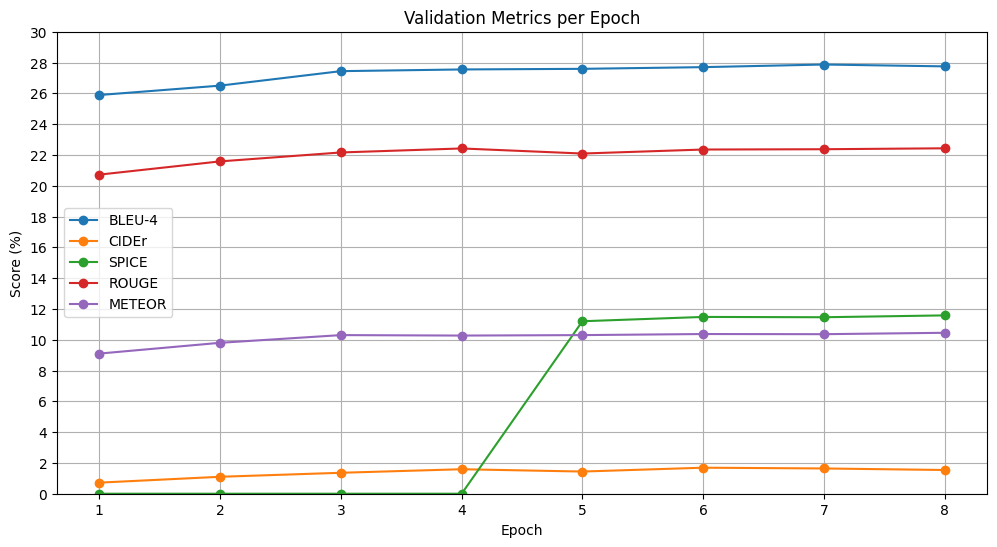

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Epochs
epochs = list(range(1, 9))

# Validation metrics (multiplied by 100 for percentage)
bleu4 = [v * 100 for v in [0.2589, 0.2650, 0.2744, 0.2755, 0.2759, 0.2770, 0.2787, 0.2775]]
cider = [v * 100 for v in [0.0072, 0.0110, 0.0136, 0.0159, 0.0144, 0.0169, 0.0164, 0.0154]]
spice = [v * 100 for v in [0.0000, 0.0000, 0.0000, 0.0000, 0.1120, 0.1148, 0.1146, 0.1158]]
rouge = [v * 100 for v in [0.2072, 0.2158, 0.2216, 0.2242, 0.2209, 0.2235, 0.2237, 0.2243]]
meteor = [v * 100 for v in [0.0910, 0.0980, 0.1030, 0.1027, 0.1030, 0.1037, 0.1036, 0.1045]]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, bleu4, marker='o', label='BLEU-4')
plt.plot(epochs, cider, marker='o', label='CIDEr')
plt.plot(epochs, spice, marker='o', label='SPICE')
plt.plot(epochs, rouge, marker='o', label='ROUGE')
plt.plot(epochs, meteor, marker='o', label='METEOR')

# Labels and title
plt.xlabel('Epoch')
plt.ylabel('Score (%)')
plt.title('Validation Metrics per Epoch')
plt.legend()
plt.grid(True)

# Set y-limit and ticks to ensure 28 is shown
plt.ylim(0, 30)
plt.yticks(np.arange(0, 31, 2))  # 0, 2, 4, ..., 28, 30 — guarantees 28 is shown

plt.show()


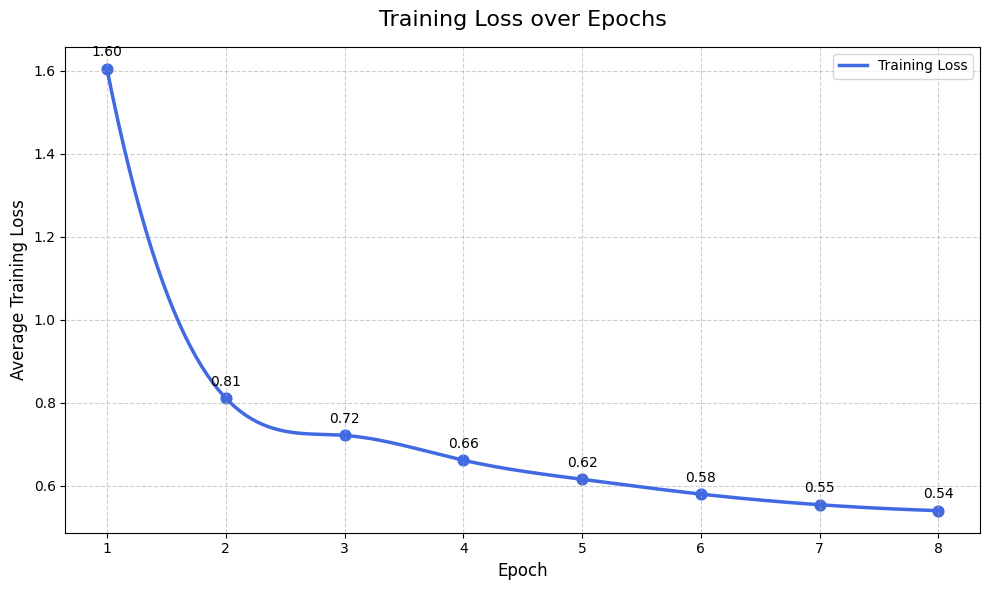

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Data
epochs = np.array([1, 2, 3, 4, 5, 6, 7, 8])
train_losses = np.array([1.6039, 0.8115, 0.7217, 0.6620, 0.6160, 0.5804, 0.5548, 0.5406])

# Smoothing
x_smooth = np.linspace(epochs.min(), epochs.max(), 300)
spline = make_interp_spline(epochs, train_losses, k=3)
y_smooth = spline(x_smooth)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=2.5, label='Training Loss')
plt.scatter(epochs, train_losses, color='royalblue', s=60)

# Add loss values at each epoch
for x, y in zip(epochs, train_losses):
    plt.text(x, y + 0.03, f"{y:.2f}", ha='center', fontsize=10)

# Labels
plt.title("Training Loss over Epochs", fontsize=16, pad=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average Training Loss", fontsize=12)
plt.xticks(epochs, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
